# Load libraries and data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
# Display up to 100 rows of data
pd.options.display.min_rows = 100

data = pd.read_csv('data/final_merged_data.csv')

For each show, each episode we have sentiment analysis metrics + viewership (millions) of the debut release.
Each measure appears 3 times corresponding to different acts within an episode. We have 129 measures from the sentiment analysis output / 3 acts correspond to **43 emotions per act**.

***NLP Dictionary***:
- Sd_div_mean: Aims to assess how quickly a consumer becomes immersed in a story—both mentally and emotionally. Become absorbed in the narrative. By dividing the standard deviation of overall emotion scores by the mean, this measurement captures the shifts, variability, and intensity of emotions throughout the experience.
- Sd_sum: Sum of the standard deviation, amount of emotion variance for each act.
- Sd_scaled: Standard deviation scaled across all emotions for ease of comparison.
- Anger
- Surprise
- Disgust
- Sadness
- Neutral
- Fear
- Joy
- Positive
- Negative
- Engaged: High ssychological involvement or emotional investment, including greater use of personal pronouns, more emotional words, and greater cognitive processing contained in the act.
- Not Engaged: Low psychological involvement or emotional investment, including lesser use of personal pronouns, less emotional words, and less cognitive processing contained in the act.
- WC: Total word count contained in the act.
- Analytic: Analytical, formal, or logical discussion contained in the act.
- Clout: Social status, confidence, or leadership discussion contained in the act.
- Authenticity: Honest, non-filtered, non-regulated discussion contained in the act.
- Tone: The higher the tone, the more positive the tone in the act (below 50 is considered negative).
- WPS: Average words per sentence.
- Six letter: Percentage of words longer than six letters.
- Dic: Percentage of words that were captured as dictionary words.
- Cogprocess: An aggregate measurement that looks at the amount of words that reflect active information processing and mental activities, including causation contained in the act.
    - Insight: Considers realizations.
    - Cause: Examines causation between two elements.
    - Discrep: Considers what should, could, or would have happened, but never did, (exploring counterfactuals).
    - Tentative: Looks at whether something could or could not happen (e.g. maybe, perhaps).
    - Certain: Looks at absolute language (e.g. always, never).
    - Differ (Is this differentiate?): Considers differentiation between two elements such as (hasn’t , but, else).
- Perceptual: An aggregate measurement of terms that describe perception, such as look, heard, and feeling.
    - See: Amount of text around viewing or seeing.
    - Hear: Amount of text around hearing or listening.
    - Feel: Looks at references to touch or feeling.
- Drives: An aggregate measurement that looks at different motivations.
    - Affiliation: Looks at relations and affiliations such as ally, friend, or being social.
    - Achieve: Considers the ability to win, earn success, and be better.
    - Power: Examines power dynamics and structures including superiority and bullying.
    - Reward: Examines the types of rewards that are discussed including receiving something, prizes, and benefits.
    - Risk: Examines the different types of dangers and doubts.
- Relativity: Aggregate measure extends toward spatial relationships such as area, bend, and exit.
    - Motion: Examines the ability to move, including arrive, car, and go.
    - Space: Examines directions in space, including down, and in.
    - Time: Examines time durations, including end, until and season.


# Cleaning

In [160]:
data.head()

,Show,Season,Episode,sd_div_mean_1,sd_div_mean_2,sd_div_mean_3,sd_sum_1,sd_sum_2,sd_sum_3,sd_scaled_1,...,time_2,time_3,vw,Genre,Network,No.of episodes,No.of seasons,Year,Air Date,Cancelled
0,2 Broke Girls,1,1,5658.359420,9159.676336,4626.990287,18.665142,20.545673,21.697182,598.633647,...,3.005714,2.572500,19.37,Sitcom,CBS,138,6,2011,2011-09-19,1.0
1,2 Broke Girls,1,2,6280.502095,3451.804293,7127.226694,19.733889,20.345823,17.440190,629.842904,...,4.335714,3.932857,11.75,Sitcom,CBS,138,6,2011,2011-09-26,1.0
2,2 Broke Girls,1,3,3931.604095,3977.461758,5506.511934,21.559420,20.759948,19.837830,694.243568,...,2.487143,3.273750,11.42,Sitcom,CBS,138,6,2011,2011-10-03,1.0
3,2 Broke Girls,1,4,5899.921656,7097.733100,3386.857917,21.267363,20.248501,19.434308,684.387650,...,3.747143,4.097143,10.71,Sitcom,CBS,138,6,2011,2011-10-10,1.0
4,2 Broke Girls,1,6,9570.497331,5883.807213,6103.310464,20.229745,21.176403,21.713179,648.841555,...,4.930000,3.623750,11.19,Sitcom,CBS,138,6,2011,2011-10-24,1.0


In [161]:
len(data.Show.unique())

235

In [1]:
data.head()

NameError: name 'data' is not defined

In [162]:
data.groupby('Cancelled')['Show'].nunique()

Cancelled
0.0    150
1.0     49
2.0     30
Name: Show, dtype: int64

235 Shows. 

In [163]:
# Filter Shows based on minimum number of episodes threshold
min_episodes_threshold = 5  # Adjust as needed

# Number of episodes per show
episode_counts = data.groupby('Show').size()
shows_to_keep = episode_counts[episode_counts >= min_episodes_threshold].index

data = data[data['Show'].isin(shows_to_keep)]

In [164]:
# Check missing values
data.isna().sum().sort_values(ascending = False).head(5)

Cancelled    397
Genre         75
cause_1        1
percept_2      1
percept_1      1
dtype: int64

In [165]:
# Which shows we dont know if they were cancelled?
data[data.Cancelled.isna()].Show.value_counts()

Show
Murphy Brown            164
Dallas                   75
Louie                    60
Arrested Development     53
NCIS: Hawaiʻi            45
Name: count, dtype: int64

In [166]:
# Lets assume for now they naturally terminated
data.Cancelled = data.Cancelled.fillna(2)

In [167]:
# Display a statistical summary of the 'Viewership (millions)' column
data['vw'].describe().T

count    25849.000000
mean        10.664304
std          7.816213
min          0.049000
25%          4.830000
50%          9.080000
75%         14.900000
max         58.530000
Name: vw, dtype: float64

In [168]:
# Many genres
data['Genre'].unique()

array(['Sitcom', 'Serial drama', 'Procedural drama', 'Family drama',
       'Mockumentary', 'Science fantasy', 'Comedy drama',
       'Animated sitcom', 'Superhero', 'Comedy-drama', 'Black comedy',
       'Crime drama', 'Drama', 'Police procedural', 'Medical drama',
       'Legal drama', 'Supernatural', 'Crime', 'Mystery', 'Action', nan,
       'Western', 'Political thriller', 'Comedy', 'Musical', 'Teen drama',
       'Adult animation', 'Family sitcom', 'Anthology', 'Sports drama',
       'Supernatural drama', 'Fantasy', 'Adventure',
       'Psychological horror', 'Legal thriller', 'Variety',
       'Action drama', 'Neo-Western', 'Sketch comedy', 'News satire',
       'Action-adventure', 'Period drama', 'Political drama',
       'Procedural', 'Docu-reality', 'Adventure drama',
       'Historical drama', 'Action fiction', 'Romantic comedy',
       'Reality competition', 'Cringe comedy', 'Talk show',
       'Psychological thriller', 'Horror', 'Science fiction',
       'Political satire',

In [171]:
# Action and Adventure
data.loc[data['Genre'].str.contains('action', case=False, na=False) 
        | data['Genre'].str.contains('adventure', case=False, na=False)
        | data['Genre'].str.contains('superhero', case=False, na=False), 'Genre'] = 'Action & Adventure'

# Comedy-drama
data.loc[data['Genre'] == 'Comedy drama', 'Genre'] = 'Comedy-drama'

# Police Procedural
genre_mapping = {
    # Police and Procedural
    'Crime': 'Crime & Police Procedural',
    'Crime drama': 'Crime & Police Procedural',
    'Procedural': 'Crime & Police Procedural',
    'Procedural drama': 'Crime & Police Procedural',
    'Police Procedural': 'Crime & Police Procedural',
    'Mystery': 'Crime & Police Procedural'
}
data['Genre'] = data['Genre'].map(genre_mapping).fillna(data['Genre'])

# Sitcom
data.loc[data['Genre'].str.contains('sitcom', case=False, na=False), 'Genre'] = 'Sitcom'
data.loc[data['Genre'] == 'Mockumentary', 'Genre'] = 'Sitcom'

# Comedy
data.loc[(data['Genre'] != 'Comedy-drama') 
        & (data['Genre'].str.contains('comedy', case=False, na=False)), 'Genre'] = 'Comedy'

# Legal
data.loc[data['Genre'].str.contains('legal', case=False, na=False), 'Genre'] = 'Legal'

# Sci-fi and Fantasy
genre_mapping = {
    # Fantasy and Sci-Fi
    'Fantasy': 'Fantasy and Sci-Fi',
    'Science fantasy': 'Fantasy and Sci-Fi',
    'Science fiction': 'Fantasy and Sci-Fi',
    'Supernatural': 'Fantasy and Sci-Fi',
    'Supernatural drama': 'Fantasy and Sci-Fi'
}
data['Genre'] = data['Genre'].map(genre_mapping).fillna(data['Genre'])

# Drama
data.loc[(data['Genre'] != 'Comedy-drama') 
        & (data['Genre'].str.contains('drama', case=False, na=False)
        | data['Genre'].str.contains('thriller', case=False, na=False)), 'Genre'] = 'Drama'

# Others
genres_cnt_shows = data.groupby('Genre').Show.nunique()
genres_low_cnt = genres_cnt_shows[genres_cnt_shows < 10].index
data.loc[data['Genre'].isin(genres_low_cnt), 'Genre'] = 'Others'

In [172]:
data.groupby('Genre').Show.nunique()

Genre
Action & Adventure           18
Comedy                       14
Comedy-drama                 15
Crime & Police Procedural    30
Drama                        39
Fantasy and Sci-Fi           10
Legal                        10
Others                       16
Police procedural            14
Sitcom                       62
Name: Show, dtype: int64

In [173]:
genre_mapping = {
    'Action': 'Action and Adventure',
    'Action drama': 'Action and Adventure',
    'Action fiction': 'Action and Adventure',
    'Action-adventure': 'Action and Adventure',
    'Adult animation': 'Others',
    'Adventure': 'Action and Adventure',
    'Adventure drama': 'Action and Adventure',
    'Animated sitcom': 'Sitcom',
    'Anthology': 'Others',
    'Black comedy': 'Comedy',
    'Comedy': 'Comedy',
    'Comedy drama': 'Comedy-drama',
    'Comedy horror': 'Comedy',
    'Comedy-drama': 'Comedy-drama',
    'Crime': 'Crime',
    'Crime drama': 'Crime',
    'Cringe comedy': 'Comedy',
    'Docu-reality': 'Reality and Documentary',
    'Drama': 'Drama',
    'Family drama': 'Drama',
    'Family sitcom': 'Comedy',
    'Fantasy': 'Fantasy and Sci-Fi',
    'Historical drama': 'Historical and Period',
    'Horror': 'Horror and Thriller',
    'Legal drama': 'Drama',
    'Legal thriller': 'Thriller',
    'Medical drama': 'Drama',
    'Mockumentary': 'Reality and Documentary',
    'Musical': 'Other/Unclassified',
    'Mystery': 'Thriller',
    'Neo-Western': 'Historical and Period',
    'News satire': 'Other/Unclassified',
    'Period drama': 'Historical and Period',
    'Period sitcom': 'Comedy',
    'Police procedural': 'Crime',
    'Political drama': 'Drama',
    'Political satire': 'Other/Unclassified',
    'Political thriller': 'Thriller',
    'Procedural': 'Crime',
    'Procedural drama': 'Crime',
    'Psychological drama': 'Drama',
    'Psychological horror': 'Horror and Thriller',
    'Psychological thriller': 'Thriller',
    'Reality competition': 'Reality and Documentary',
    'Romantic comedy': 'Comedy',
    'Science fantasy': 'Fantasy and Sci-Fi',
    'Science fiction': 'Fantasy and Sci-Fi',
    'Serial drama': 'Drama',
    'Sitcom': 'Comedy',
    'Sketch comedy': 'Comedy',
    'Sports drama': 'Drama',
    'Superhero': 'Action',
    'Supernatural': 'Fantasy and Sci-Fi',
    'Supernatural drama': 'Fantasy and Sci-Fi',
    'Talk show': 'Other/Unclassified',
    'Teen drama': 'Drama',
    'Variety': 'Other/Unclassified',
    'Western': 'Historical and Period'
}

#data['Genre'] = data['Genre'].map(genre_mapping).fillna(data['Genre'])

# Exploring

In [174]:
# Which genres experience more variance in the viewership
print(data.groupby('Genre').vw.std().sort_values(ascending = False).head(5))
data.groupby('Genre').vw.std().sort_values(ascending = False).tail(5)

Genre
Sitcom          9.102559
Comedy          8.410408
Drama           7.319115
Comedy-drama    7.122774
Legal           6.712140
Name: vw, dtype: float64


Genre
Crime & Police Procedural    6.183450
Fantasy and Sci-Fi           6.028595
Police procedural            5.679598
Action & Adventure           5.630719
Others                       4.990355
Name: vw, dtype: float64

In [139]:
print(data.groupby('Show').vw.std().sort_values(ascending = False).head(5))
data.groupby('Show').vw.std().sort_values(ascending = False).tail(5)

Show
ER                   9.140101
A Different World    8.138627
Roseanne             8.096697
The Cosby Show       7.948770
Empty Nest           7.538348
Name: vw, dtype: float64


Show
What We Do in the Shadows    0.106330
How To with John Wilson      0.103228
Succession                   0.101541
Yellowjackets                0.080540
Portlandia                   0.053403
Name: vw, dtype: float64

In [145]:
print(data.groupby(['Show','Cancelled','Genre']).vw.std().sort_values(ascending = False).head(10))

Show                            Cancelled  Genre            
ER                              0.0        Medical drama        9.140101
A Different World               0.0        Sitcom               8.138627
Roseanne                        1.0        Sitcom               8.096697
The Cosby Show                  0.0        Sitcom               7.948770
Empty Nest                      0.0        Sitcom               7.538348
Moonlighting                    1.0        Comedy drama         7.455715
Seinfeld                        0.0        Sitcom               7.387463
Home Improvement                0.0        Sitcom               7.326406
CSI: Crime Scene Investigation  0.0        Police procedural    7.091071
The Golden Girls                0.0        Sitcom               6.097400
Name: vw, dtype: float64


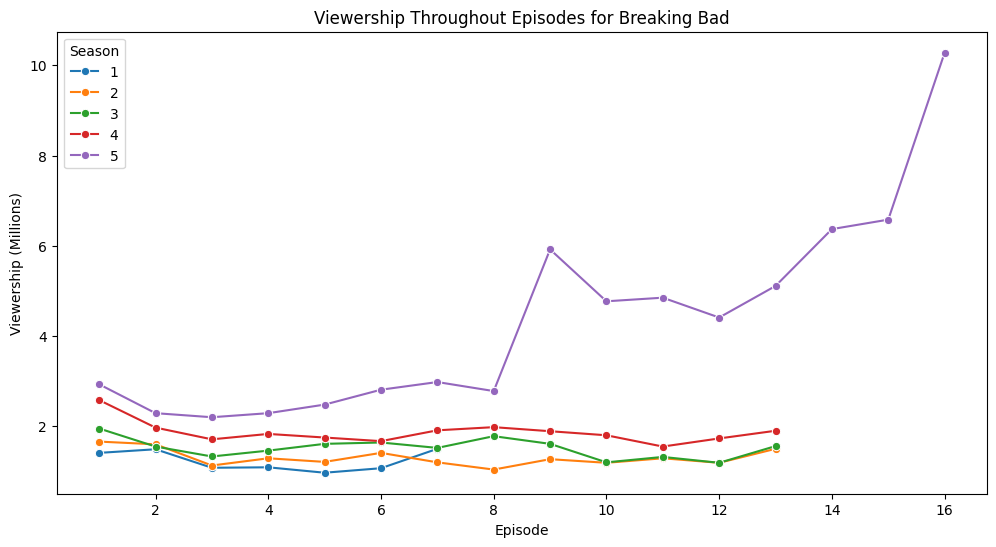

In [12]:
# Filter data for the specific show
specific_show = 'Breaking Bad'  # Replace with the name of the show you want to plot
show_data = data[data['Show'] == specific_show]

# Plot viewership by episode with season as a legend
plt.figure(figsize=(12, 6))
sns.lineplot(data=show_data, x='Episode', y='vw', hue='Season', marker='o', palette='tab10')

# Add labels and title
plt.title(f'Viewership Throughout Episodes for {specific_show}')
plt.xlabel('Episode')
plt.ylabel('Viewership (Millions)')
plt.legend(title='Season')
plt.show()

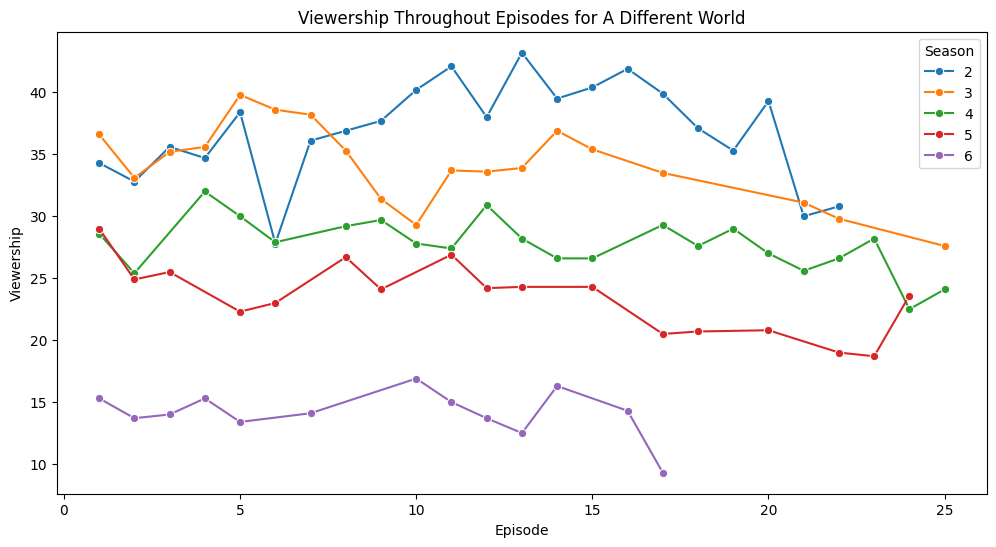

In [148]:
# Filter data for the specific show
specific_show = 'A Different World'  # Replace with the name of the show you want to plot
show_data = data[data['Show'] == specific_show]

# Plot viewership by episode with season as a legend
plt.figure(figsize=(12, 6))
sns.lineplot(data=show_data, x='Episode', y='vw', hue='Season', marker='o', palette='tab10')

# Add labels and title
plt.title(f'Viewership Throughout Episodes for {specific_show}')
plt.xlabel('Episode')
plt.ylabel('Viewership')
plt.legend(title='Season')
plt.show()

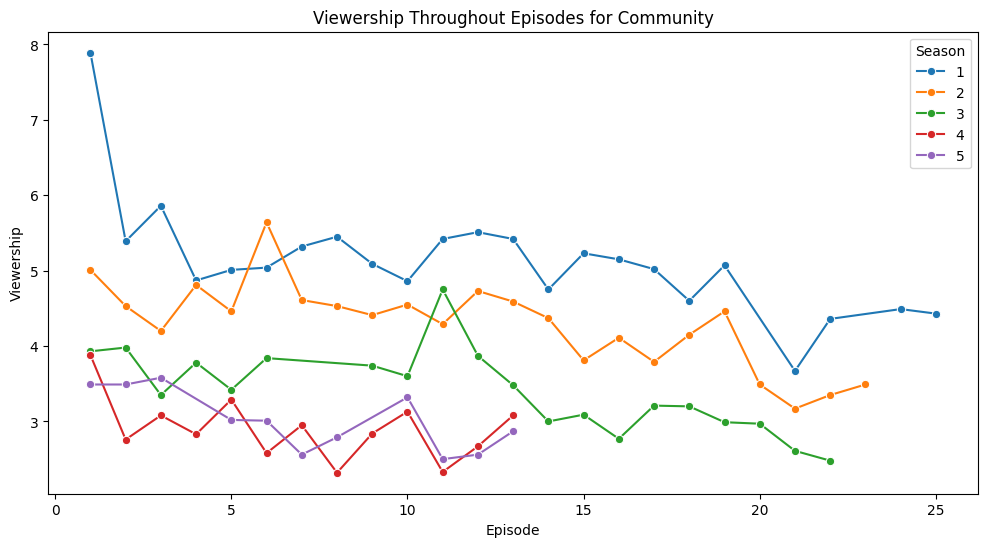

In [43]:
# Filter data for the specific show
specific_show = 'Community'  # Replace with the name of the show you want to plot
show_data = data[data['Show'] == specific_show]

# Plot viewership by episode with season as a legend
plt.figure(figsize=(12, 6))
sns.lineplot(data=show_data, x='Episode', y='vw', hue='Season', marker='o', palette='tab10')

# Add labels and title
plt.title(f'Viewership Throughout Episodes for {specific_show}')
plt.xlabel('Episode')
plt.ylabel('Viewership')
plt.legend(title='Season')
plt.show()

In [167]:
data['vw_next'] = data.groupby(['Show', 'Season'])['vw'].diff()
# Moving avg of 3 episodes
data['moving_avg_vw'] = data.groupby(['Show', 'Season'])['vw'].rolling(window=3, min_periods=1).mean().reset_index(drop = True)
data.head()

,Show,Season,Episode,sd_div_mean_1,sd_div_mean_2,sd_div_mean_3,sd_sum_1,sd_sum_2,sd_sum_3,sd_scaled_1,...,vw,Genre,Network,No.of episodes,No.of seasons,Year,Air Date,Cancelled,vw_next,moving_avg_vw
0,2 Broke Girls,1,1,5658.359420,9159.676336,4626.990287,18.665142,20.545673,21.697182,598.633647,...,19.37,Sitcom,CBS,138,6,2011,2011-09-19,1.0,NaN,19.370000
1,2 Broke Girls,1,2,6280.502095,3451.804293,7127.226694,19.733889,20.345823,17.440190,629.842904,...,11.75,Sitcom,CBS,138,6,2011,2011-09-26,1.0,-7.62,15.560000
2,2 Broke Girls,1,3,3931.604095,3977.461758,5506.511934,21.559420,20.759948,19.837830,694.243568,...,11.42,Sitcom,CBS,138,6,2011,2011-10-03,1.0,-0.33,14.180000
3,2 Broke Girls,1,4,5899.921656,7097.733100,3386.857917,21.267363,20.248501,19.434308,684.387650,...,10.71,Sitcom,CBS,138,6,2011,2011-10-10,1.0,-0.71,11.293333
4,2 Broke Girls,1,6,9570.497331,5883.807213,6103.310464,20.229745,21.176403,21.713179,648.841555,...,11.19,Sitcom,CBS,138,6,2011,2011-10-24,1.0,0.48,11.106667


In [168]:
data[~ data.vw_next.isna()].sort_values(by='vw_next').tail(5)

,Show,Season,Episode,sd_div_mean_1,sd_div_mean_2,sd_div_mean_3,sd_sum_1,sd_sum_2,sd_sum_3,sd_scaled_1,...,vw,Genre,Network,No.of episodes,No.of seasons,Year,Air Date,Cancelled,vw_next,moving_avg_vw
19703,Seinfeld,9,21,5687.754703,25113.350355,17759.851183,22.408289,21.493873,22.275117,720.232334,...,58.53,Sitcom,NBC,180,9,1989,1998-05-14,0.0,19.75,4.333333
8894,Friends,2,13,9188.964156,14082.348683,30702.633149,21.637994,20.855862,21.227977,694.352434,...,52.90,Sitcom,NBC,236,10,1994,1996-01-28,0.0,21.30,30.500000
529,3rd Rock from the Sun,3,14,4581.773926,3784.822150,6938.968934,21.342302,21.116801,19.504064,683.813277,...,33.66,Sitcom,NBC,139,6,1996,1998-01-25,0.0,22.45,19.073333
21674,The Cosby Show,8,24,4754.898438,4111.980378,19559.615936,20.556478,22.476991,22.844686,658.655546,...,44.40,Sitcom,NBC,201,8,1984,1992-04-30,0.0,22.50,14.300000
9085,Friends,10,17,4957.485097,75124.436099,8130.979440,20.022950,20.604955,20.659120,647.673998,...,52.46,Sitcom,NBC,236,10,1994,2004-05-06,0.0,27.95,22.733333


In [ ]:
data['prolonged_uptake'] = (data['moving_avg_vw'] > data['moving_avg_vw'].shift(1)) & (data['viewership_change'] > uptake_threshold * data['moving_avg_vw'].shift(1))